In [1]:
from edge_probing_utils import (
    JiantDatasetSingleSpan,
    JiantDatasetTwoSpan
    )
import edge_probing as ep
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import AutoModel, AutoTokenizer


**Setup:**

In [2]:
tasks = [
    #"ner", 
    #"semeval",
    "coref",
    #"sup-squad",
    #"ques",
    #"sup-babi",
    #"sup-hotpot",
    ]

task_types = {
    "ner": "single_span", 
    "semeval": "single_span",
    "coref": "two_span",
    "sup-squad": "two_span",
    "ques": "single_span",
    "sup-babi": "two_span",
    "sup-hotpot": "two_span",
    }

models = [
    "roberta-base",
    #"bert-base-uncased", 
    #"csarron/bert-base-uncased-squad-v1",
    #"../../models/BERT_fineTunned_on_AdversarialQA_trained",
    ]

task_labels_to_ids = {
    "ner": {'ORDINAL': 0, 'DATE': 1, 'PERSON': 2, 'LOC': 3, 'GPE': 4, 'QUANTITY': 5, 'ORG': 6, 'WORK_OF_ART': 7, 'CARDINAL': 8, 'TIME': 9, 'MONEY': 10, 'LANGUAGE': 11, 'NORP': 12, 'PERCENT': 13, 'EVENT': 14, 'LAW': 15, 'FAC': 16, 'PRODUCT': 17},
    "coref": {"0": 0, "1": 1},
    "semeval": {'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Entity-Destination(e1,e2)': 4, 'Content-Container(e1,e2)': 5, 'Message-Topic(e1,e2)': 6, 'Cause-Effect(e2,e1)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18},
    "sup-squad": {"0": 0, "1": 1},
    "ques": {'LOC:other': 0, 'DESC:desc': 1, 'DESC:def': 2, 'DESC:manner': 3, 'ENTY:sport': 4, 'ENTY:termeq': 5, 'HUM:ind': 6, 'NUM:count': 7, 'DESC:reason': 8, 'LOC:country': 9, 'HUM:desc': 10, 'ENTY:animal': 11, 'ENTY:other': 12, 'LOC:city': 13, 'ENTY:cremat': 14, 'NUM:perc': 15, 'NUM:money': 16, 'NUM:date': 17, 'ENTY:dismed': 18, 'LOC:state': 19, 'NUM:speed': 20, 'HUM:gr': 21, 'NUM:dist': 22, 'ENTY:food': 23, 'ABBR:abb': 24, 'ENTY:product': 25, 'HUM:title': 26, 'NUM:weight': 27, 'ABBR:exp': 28, 'ENTY:veh': 29, 'NUM:period': 30, 'ENTY:religion': 31, 'ENTY:letter': 32, 'ENTY:color': 33, 'ENTY:body': 34, 'ENTY:event': 35, 'ENTY:substance': 36, 'ENTY:instru': 37, 'ENTY:plant': 38, 'ENTY:symbol': 39, 'NUM:other': 40, 'LOC:mount': 41, 'NUM:temp': 42, 'ENTY:techmeth': 43, 'NUM:code': 44, 'ENTY:word': 45, 'ENTY:lang': 46, 'NUM:volsize': 47, 'NUM:ord': 48, 'ENTY:currency': 49},
    "sup-babi": {"0": 0, "1": 1},
    }
    
model_to_linestyle = {
    "bert-base-uncased": ":g", 
    "csarron/bert-base-uncased-squad-v1": "-y",
    "BERT_fineTunned_on_AdversarialQA_trained": "--b",
    "roberta-base": "-.r",
}

# Pick a dataset size: small, medium, big.
# With the way training works, a smaller size will only improve the speed of tokenizing,
# training speed will be the same for all sizes.
size = "medium"

In [3]:
import os
import json
import matplotlib.pyplot as plt

loss_function = nn.BCELoss()
batch_size = 32
num_layers = range(1,2,2)
num_workers = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# Disable warnings.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

os.makedirs(f"../results/", exist_ok=True)
os.makedirs(f"../intermediate-results/", exist_ok=True)


for model in models:
    tokenizer = AutoTokenizer.from_pretrained(model)
    for task in tasks:
        if os.path.isfile(f'../results/{size}.json'):
            with open(f'../results/{size}.json', 'r') as f:
                results = json.load(f)
        else:
            results = {}
        task_results = results.setdefault(task, {})
        labels_to_ids = task_labels_to_ids[task]
        train_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/train.jsonl")),
            labels_to_ids,
            max_seq_length=384
            )
        val_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/val.jsonl")),
            labels_to_ids,
            max_seq_length=384
            )
        test_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/test.jsonl")),
            labels_to_ids,
            )
        if task_types[task] == "single_span":
            train_data = JiantDatasetSingleSpan(train_data)
            val_data = JiantDatasetSingleSpan(val_data)
            test_data = JiantDatasetSingleSpan(test_data)
        elif task_types[task] == "two_span":
            train_data = JiantDatasetTwoSpan(train_data)
            val_data = JiantDatasetTwoSpan(val_data)
            test_data = JiantDatasetTwoSpan(test_data)
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
        val_loader = data.DataLoader(val_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
        test_loader = data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
        results[task][model] = ep.probing(ep.ProbeConfig(
                train_loader,
                val_loader,
                test_loader,
                model,
                num_layers,
                loss_function,
                labels_to_ids,
                task_types[task],
                lr=0.0001,
                patience=5,
                eval_interval=1000,
                dev=device,
                results_path=f"../intermediate-results/",
                ))
        with open(f'../results/{size}.json', 'w') as f:
            json.dump(results, f)

Reading ../data/coref/medium/train.jsonl



Tokenizing



Reading ../data/coref/medium/val.jsonl



Tokenizing



Reading ../data/coref/medium/test.jsonl



Tokenizing



Probing model roberta-base
Probing layer 1 of 1


Downloading: 100%|██████████| 501M/501M [00:19<00:00, 25.8MB/s]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaEdgeProbingTwoSpan: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'roberta.encoder.layer.1.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.query.bias', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.1.attention.self.value.bias', 'roberta.encoder.layer.1.attention.output.dense.weight', 'roberta.encoder.layer.1.attention.output.dense.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.intermediate.dense.weight', 'roberta.encod

Training the model


KeyboardInterrupt: 

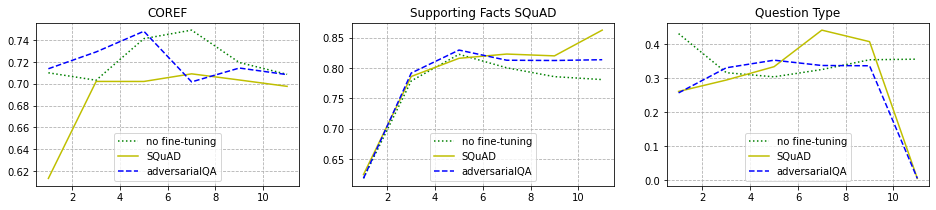

In [1]:
import json
import matplotlib.pyplot as plt
import edge_probing as ep


models = [
    "bert-base-uncased", 
    "csarron/bert-base-uncased-squad-v1",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained",
    ]
model_to_linestyle = {
    "bert-base-uncased": ":g", 
    "csarron/bert-base-uncased-squad-v1": "-y",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained": "--b",
}
model_to_label = {
    "bert-base-uncased": "no fine-tuning", 
    "csarron/bert-base-uncased-squad-v1": "SQuAD",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained": "adversarialQA",
    }
task_to_title = {
    "coref": "COREF",
    "ques": "Question Type",
    "sup-squad": "Supporting Facts SQuAD",
    }

tasks = [
    "coref",
    "sup-squad",
    "ques"
    ]
size = "big"
num_layers = range(1,13,2)

f, axs = plt.subplots(1, 3, figsize=(16, 3))
i = 0

for task in tasks:
    for model in models:
        ep.plot_task(
            f"./results/{size}.json",
            task,
            model,
            model_to_linestyle[model],
            num_layers,
            label=model_to_label[model],
            title=task_to_title[task],
            plot=axs[i]
            )
    i += 1
plt.show()